In [1]:
# ------------------------------ IMPORTS ----------------------------------------- #

# Built-in 
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

# Own Libs
from utils import read_Tumag
from field_stop_finder import compute_alignment, apply_fieldstop_and_align
from master_dark import compute_master_darks
from master_flatfield import compute_master_flat_field
import image_handler as ih
from demodulation import demodulate
from vlos import cog_profile

In [2]:
plt.style.use("default")

In [3]:
# Testeo
darks_c1 = sorted(glob.glob(f"/home/pablo/Desktop/TuMAGDATA/Darks/*_0_*")) 
darks_c2 = sorted(glob.glob(f"/home/pablo/Desktop/TuMAGDATA/Darks/*_1_*")) 

flats_c1 = sorted(glob.glob(f"/home/pablo/Desktop/TuMAGDATA/flare_set_ordered/2.02/39/*_0_*")) 
flats_c2 = sorted(glob.glob(f"/home/pablo/Desktop/TuMAGDATA/flare_set_ordered/2.02/39/*_1_*")) 

Obs_folder = "/home/pablo/Desktop/TuMAGDATA/flare_set_ordered/2.06/24/"
obs_mode = "2.06"

pinholes1 = "/home/pablo/Desktop/TuMAGDATA/flare_set_ordered/Spectral_calibration/36"
#pinholes2 = "/home/pablo/Desktop/TuMAGDATA/flare_set_ordered/Spectral_calibration/37"
#pinholes3 = "/home/pablo/Desktop/TuMAGDATA/flare_set_ordered/Spectral_calibration/38"
ph_ims_c1 = sorted(glob.glob(f"{pinholes1}/*_0_*"))
ph_ims_c2 = sorted(glob.glob(f"{pinholes1}/*_1_*"))

#Obs_folder = "/home/pablo/Desktop/TuMAGDATA/flare_set_ordered/1/23/"
#obs_mode = "1"

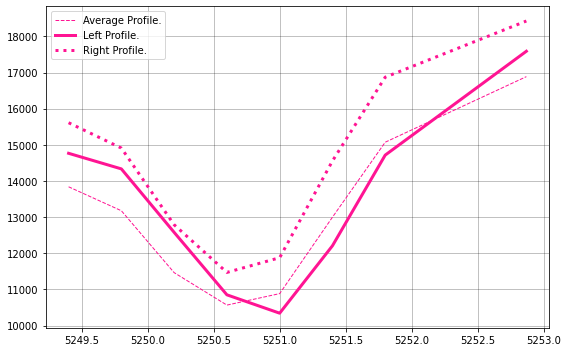

In [4]:
all_images = sorted(glob.glob(f"{Obs_folder}*"))

ob = ih.nominal_observation(obs_mode, np.array(all_images))
data = ob.get_data()

# Only continuum
info = ob.get_info()

cont = data[:, -1, :]

if obs_mode == "1":
    l0 = 5173

if obs_mode == "2.06":
    l0 = 5250.6

wls = np.array(info["lambda_array"]) * 10E-3 + l0
vlos = cog_profile(data[0, :, 0, 200:1750, 200:1750], wave_axis= wls, wave = l0)

plt.figure(figsize = (8, 5))

colors = ["deeppink", "gold", "cyan", "crimson"]
for mod in range(1):
    av_int = []
    left_int = []
    right_int = []
    for i in range(info["Nlambda"]):
        av_int.append(np.mean(data[0, i, mod, 200:1750, 200:1750]))
        left_int.append(np.mean(data[0, i, mod, 250:1750, 200:450]))
        right_int.append(np.mean(data[0, i, mod, 250:1750, 1500:1750]))

    plt.plot(wls, av_int, c = colors[mod], ls = '--', lw = 1, label = "Average Profile.")
    plt.plot(wls, left_int, c = colors[mod], ls = '-', lw = 3, label = "Left Profile.")
    plt.plot(wls, right_int, c = colors[mod], ls = ':', lw = 3, label = "Right Profile.")

#plt.plot([l0, l0], [4000, 14000], c = "k", ls = '--')
plt.tight_layout()
plt.grid(True, alpha = 0.3, c = 'k')

plt.legend()
plt.show()

del data


Computing alignment with pinholes..
Computing correlation...
Finding fieldstop field stop...
[1814, 1815, 1814, 1814, 1815]


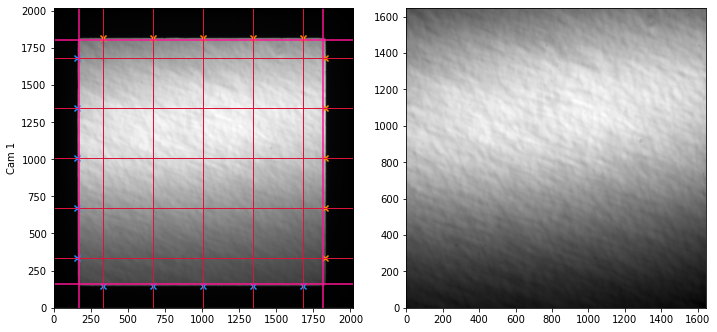

Cam 1 Field stop: [[ 158 1804]
 [ 171 1816]]
Height : 1646
Width : 1645
Field stop computation finished in 1.209s.


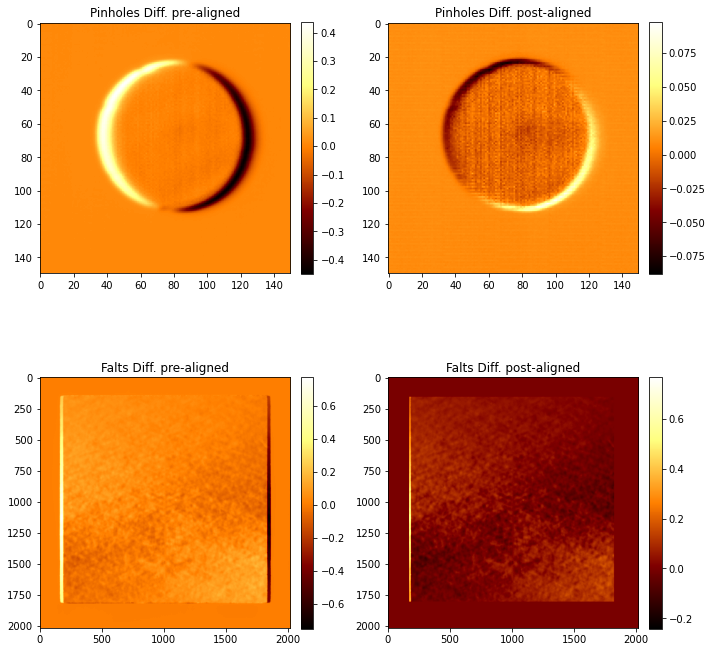

Shift between cameras : X =  -1 - Y - -4 
Computing darks ...
N darks for cam1 : 6
N darks for cam2 : 6
Dark current computed in 0.759 s.
Computing flats ...
N flats for cam1 : 20
N flats for cam2 : 20
Flat-fields computed in 2.871 s.
CAM 1 - Adjusted Height : 1646 - Width : 1645
CAM 2 - Adjusted Height : 1646 - Width : 1645


In [5]:
c1, _ = read_Tumag(flats_c1[0])
c2, _ = read_Tumag(flats_c2[0])
#fs_c1, fs_c2 = compute_alignment(flat_cam1=c1 / np.max(c1), flat_cam2= c2 / np.max(c2), method = 'flats', plot_flag=True, verbose = True)
fs_c1, fs_c2 = compute_alignment(flat_cam1=c1 / np.max(c1), flat_cam2= c2 / np.max(c2), pinhole_c1_path=ph_ims_c1[0], pinhole_c2_path=ph_ims_c2[0], method = 'pinhole', plot_flag=True, verbose = True)



dc = compute_master_darks(darks_c1, darks_c2, verbose = True)
ff = compute_master_flat_field(flats_c1, flats_c2, dc, verbose = True)

dc[0], dc[1] = apply_fieldstop_and_align(dc[0], dc[1], fs_c1, fs_c2)
ff[0], ff[1] = apply_fieldstop_and_align(ff[0], ff[1], fs_c1, fs_c2)

print(f"CAM 1 - Adjusted Height : {fs_c1[0][1] - fs_c1[0][0]} - Width : {fs_c1[1][1] - fs_c1[1][0]}")
print(f"CAM 2 - Adjusted Height : {fs_c2[0][1] - fs_c2[0][0]} - Width : {fs_c2[1][1] - fs_c2[1][0]}")


/tmp/ipykernel_126501/3398524272.py:34: RuntimeWarning: invalid value encountered in divide
  corrected[1, mod] = (cont[0,mod] - dc[0]) / ff[0]
/tmp/ipykernel_126501/3398524272.py:35: RuntimeWarning: invalid value encountered in divide
  corrected[0, mod] = (cont[1,mod] - dc[1]) / ff[1]


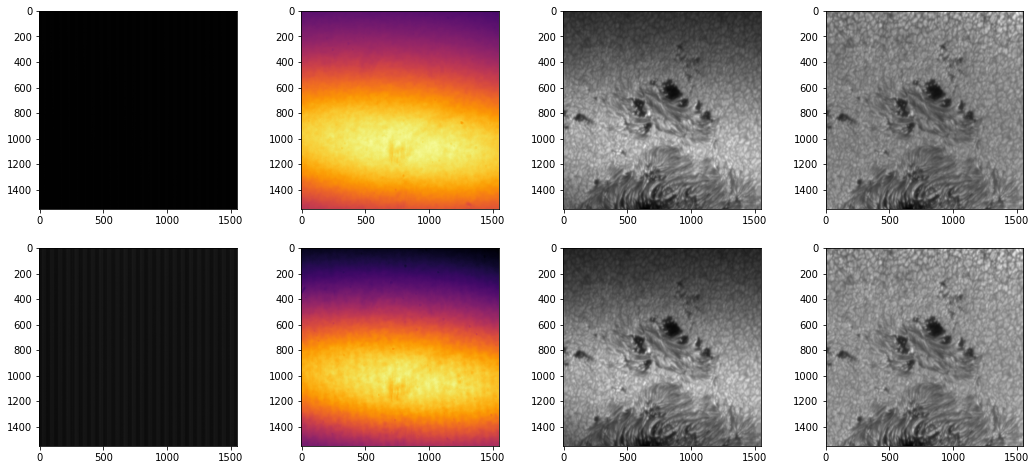

In [6]:
"""
info = ob.get_info()
corrected = np.zeros((2, info["Nmods"], info["Nlambda"], 1666, 1665))

for mod in range(info["Nmods"]):
    for lamb in range(info["Nlambda"]):
        corrected[0, mod, lamb] = (data[0, lamb, mod, fs_obs_c1[0][0]:fs_obs_c1[0][1], fs_obs_c1[1][0]:fs_obs_c1[1][1]] - dc_obs[0, fs_obs_c1[0][0]:fs_obs_c1[0][1], fs_obs_c1[1][0]:fs_obs_c1[1][1]]) / ff[0,fs_obs_c1[0][0]:fs_obs_c1[0][1], fs_obs_c1[1][0]:fs_obs_c1[1][1]]
        corrected[1, mod, lamb] = (data[1, lamb, mod, fs_obs_c2[0][0]:fs_obs_c2[0][1], fs_obs_c2[1][0]:fs_obs_c2[1][1]] - dc_obs[1, fs_obs_c2[0][0]:fs_obs_c2[0][1], fs_obs_c2[1][0]:fs_obs_c2[1][1]]) / ff[1,fs_obs_c2[0][0]:fs_obs_c2[0][1], fs_obs_c2[1][0]:fs_obs_c2[1][1]]

fig, axs = plt.subplots(2, 4, figsize = (18, 8))

axs[0, 0].imshow(dc_obs[0, fs_obs_c1[0][0]:fs_obs_c1[0][1], fs_obs_c1[1][0]:fs_obs_c1[1][1]], vmin = 2000, cmap = "gray")
axs[1, 0].imshow(dc_obs[1, fs_obs_c2[0][0]:fs_obs_c2[0][1], fs_obs_c2[1][0]:fs_obs_c2[1][1]], vmin = 2000, cmap = "gray")

axs[0, 1].imshow(ff[0,fs_obs_c1[0][0]:fs_obs_c1[0][1], fs_obs_c1[1][0]:fs_obs_c1[1][1]], cmap = 'inferno')
axs[1, 1].imshow(ff[1,fs_obs_c2[0][0]:fs_obs_c2[0][1], fs_obs_c2[1][0]:fs_obs_c2[1][1]], cmap = 'inferno')

axs[1, 2].imshow(data[0, 0, -1, fs_obs_c1[0][0]:fs_obs_c1[0][1], fs_obs_c1[1][0]:fs_obs_c1[1][1]], cmap = "gray")#, vmin = np.mean(data[0, 0, -1]) - np.std(data[0, 0, -1]) * 3, vmax = np.mean(data[0, 0, -1]) + 3 * np.std(data[0, 0, -1]))
axs[0, 2].imshow(data[1, 0, -1, fs_obs_c2[0][0]:fs_obs_c2[0][1], fs_obs_c2[1][0]:fs_obs_c2[1][1]], cmap = "gray")#, vmin = np.mean(data[0, 0, -1]) - np.std(data[0, 0, -1]) * 3, vmax = np.mean(data[0, 0, -1]) + 3 * np.std(data[0, 0, -1]))


axs[1, 3].imshow(corrected[0, 0, -1], cmap = "gray", vmin = np.mean(corrected[0, 0, -1]) - np.std(corrected[0, 0, -1]) * 3, vmax = np.mean(corrected[0, 0, -1]) + 3 * np.std(corrected[0, 0, -1]))
axs[0, 3].imshow(corrected[1, 0, -1], cmap = "gray", vmin = np.mean(corrected[1, 0, -1]) - np.std(corrected[1, 0, -1]) * 3, vmax = np.mean(corrected[1, 0, -1]) + 3 * np.std(corrected[1, 0, -1]))

plt.tight_layout()"""

corrected = np.zeros((2, info["Nmods"], 2016, 2016))
#corrected = np.zeros((np.shape(data)))

for mod in range(info["Nmods"]):
    #for lamb in range(info["Nlambda"]):

    cont[0, mod], cont[1, mod] = apply_fieldstop_and_align(cont[0, mod], cont[1, mod], fs_c1, fs_c2)
    corrected[1, mod] = (cont[0,mod] - dc[0]) / ff[0]
    corrected[0, mod] = (cont[1,mod] - dc[1]) / ff[1]

        #data[0, lamb, mod], data[1,lamb, mod] = apply_fieldstop_and_align(data[0, lamb, mod], data[1,lamb, mod], #fs_c1, fs_c2)
        #corrected[1, lamb, mod] = (data[0,lamb,mod] - dc[0]) / ff[0]#
        #corrected[0, lamb, mod] = (data[1,lamb,mod] - dc[1]) / ff[1]

fig, axs = plt.subplots(2, 4, figsize = (18, 8))
axs[0, 0].imshow(dc[0, 200:1750, 200:1750], cmap = "gray")
axs[1, 0].imshow(dc[1, 200:1750, 200:1750], cmap = "gray")

axs[0, 1].imshow(ff[0, 200:1750, 200:1750], cmap = 'inferno')
axs[1, 1].imshow(ff[1, 200:1750, 200:1750], cmap = 'inferno')

axs[0, 2].imshow(cont[0, 0, 200:1750, 200:1750], cmap = "gray")
axs[1, 2].imshow(cont[1, 0, 200:1750, 200:1750], cmap = "gray")

# axs[0, 2].imshow(data[0, -1, 0, 200:1750, 200:1750], cmap = "gray")
# axs[1, 2].imshow(data[1, -1, 0, 200:1750, 200:1750], cmap = "gray")

axs[0, 3].imshow(corrected[0, 0, 200:1750, 200:1750], cmap = "gray")
axs[1, 3].imshow(corrected[1, 0, 200:1750, 200:1750], cmap = "gray")





del ff, dc





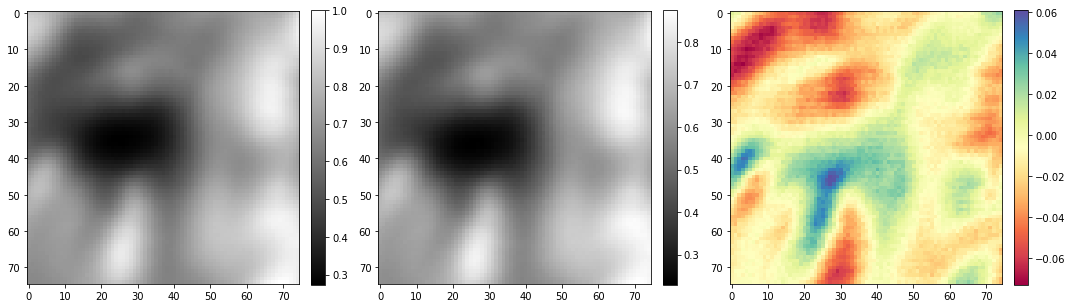

In [7]:
fig, axs = plt.subplots(1, 3, figsize = (15, 5))

cds_check_x = [950 + 125, 1150] 
cds_check_y = [200, 400 - 125] 

im = axs[0].imshow(corrected[0, 0, cds_check_x[0]:cds_check_x[1], cds_check_y[0]:cds_check_y[1]]   / np.max(corrected[0, 0, cds_check_x[0]:cds_check_x[1], cds_check_y[0]:cds_check_y[1]]), cmap = "gray")
plt.colorbar(im, fraction=0.046, pad=0.04)
im = axs[1].imshow(corrected[1, 0, cds_check_x[0]:cds_check_x[1], cds_check_y[0]:cds_check_y[1]]/ np.max(corrected[0, 0, cds_check_x[0]:cds_check_x[1], cds_check_y[0]:cds_check_y[1]]), cmap = "gray")
plt.colorbar(im, fraction=0.046, pad=0.04)
im = axs[2].imshow(corrected[0, 0, cds_check_x[0]:cds_check_x[1], cds_check_y[0]:cds_check_y[1]] / np.max(corrected[0, 0, cds_check_x[0]:cds_check_x[1], cds_check_y[0]:cds_check_y[1]]) -\
                   corrected[1, 0, cds_check_x[0]:cds_check_x[1], cds_check_y[0]:cds_check_y[1]] / np.max(corrected[1, 0, cds_check_x[0]:cds_check_x[1], cds_check_y[0]:cds_check_y[1]]), cmap = "Spectral")
plt.colorbar(im, fraction=0.046, pad=0.04)

plt.tight_layout()

In [8]:
"""from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, axs = plt.subplots(1, 2, figsize = (15, 7.55))

im1 = axs[0].imshow(corrected[0, -1, 0, 200:1750, 200:1750], cmap = "gray")


l0 = 5173
wls = np.array(info["lambda_array"]) * 1E-3 + l0
vlos = cog_profile(corrected[0, :, 0, 200:1750, 200:1750], wave_axis= wls, wave = l0, cpos = 0)

im2 = axs[1].imshow(vlos, cmap = "bwr")

divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im1, cax=cax)


divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im2, cax=cax, label = "km/s")

plt.tight_layout()"""

'from mpl_toolkits.axes_grid1 import make_axes_locatable\nfig, axs = plt.subplots(1, 2, figsize = (15, 7.55))\n\nim1 = axs[0].imshow(corrected[0, -1, 0, 200:1750, 200:1750], cmap = "gray")\n\n\nl0 = 5173\nwls = np.array(info["lambda_array"]) * 1E-3 + l0\nvlos = cog_profile(corrected[0, :, 0, 200:1750, 200:1750], wave_axis= wls, wave = l0, cpos = 0)\n\nim2 = axs[1].imshow(vlos, cmap = "bwr")\n\ndivider = make_axes_locatable(axs[0])\ncax = divider.append_axes("right", size="5%", pad=0.05)\nplt.colorbar(im1, cax=cax)\n\n\ndivider = make_axes_locatable(axs[1])\ncax = divider.append_axes("right", size="5%", pad=0.05)\nplt.colorbar(im2, cax=cax, label = "km/s")\n\nplt.tight_layout()'

In [9]:
#demod, dual = demodulate(corrected[:, :, 3], 1666, 1664, 4, 8, filt = "525.02", mode = 'single_wavelength') 
#demod, dual = demodulate(corrected, 2016, 2016, 4, 8, filt = "525.06", mode = 'standard') 
demod, dual = demodulate(corrected, 2016, 2016, 4, 8, filt = "525.06", mode = 'standard_single_wavelength') 

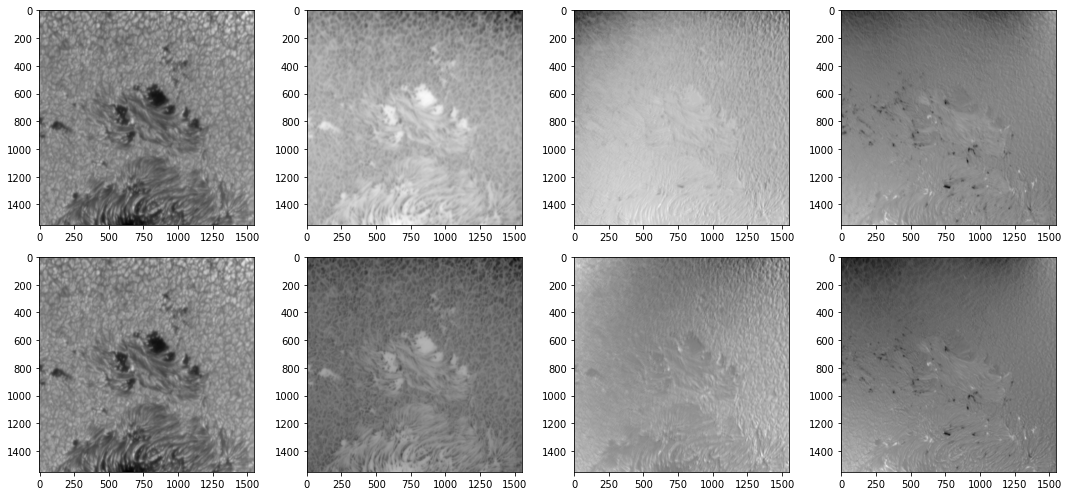

In [10]:
fig, axs = plt.subplots(2, 4, figsize = (15, 7))

axs[0, 0].imshow(demod[0, 0, 200:1750, 200:1750], cmap = "gray")
axs[0, 1].imshow(demod[0, 1, 200:1750, 200:1750], cmap = "gray")
axs[0, 2].imshow(demod[0, 2, 200:1750, 200:1750], cmap = "gray")
axs[0, 3].imshow(demod[0, 3, 200:1750, 200:1750], cmap = "gray")

axs[1, 0].imshow(demod[1, 0, 200:1750, 200:1750], cmap = "gray")
axs[1, 1].imshow(demod[1, 1, 200:1750, 200:1750], cmap = "gray")
axs[1, 2].imshow(demod[1, 2, 200:1750, 200:1750], cmap = "gray")
axs[1, 3].imshow(demod[1, 3, 200:1750, 200:1750], cmap = "gray")

plt.tight_layout()

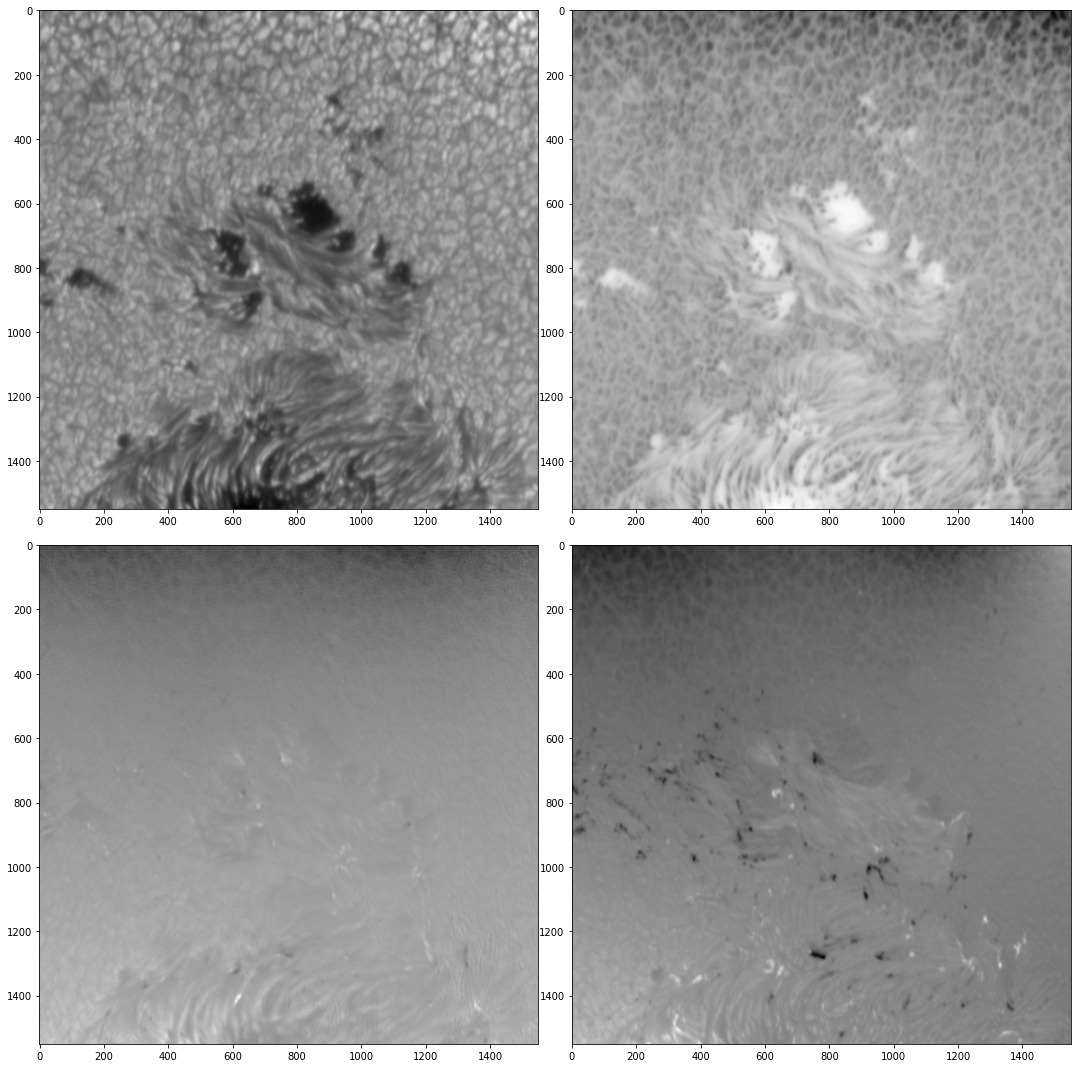

In [11]:
fig, axs = plt.subplots(2, 2, figsize = (15, 15))

axs[0, 0].imshow(dual[0,200:1750, 200:1750], cmap = "gray")
axs[0, 1].imshow(dual[1,200:1750, 200:1750], cmap = "gray")
axs[1, 0].imshow(dual[2,200:1750, 200:1750], cmap = "gray")
axs[1, 1].imshow(dual[3,200:1750, 200:1750], cmap = "gray")


plt.tight_layout()


In [12]:
np.shape(data[0, :, 0] )


NameError: name 'data' is not defined